In [102]:
import json
import pandas as pd
import numpy as np
import preprocessor as p
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from collections import Counter

from nltk import FreqDist

import spacy
import keras 

import wordcloud 
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [103]:
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

# Data loading and preprocessing

In [104]:
tweets = []
for line in open('data/cdc_twitter_covid.json', 'r', encoding='utf-8'):
    tweets.append(json.loads(line))
    
df = pd.DataFrame(tweets)

In [105]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [106]:
df = df[['id', 'date', 'time', 'username', 'tweet', 'mentions','urls', 'photos', 'hashtags', 'link', 'quote_url']]

In [107]:
tweets_df = df[['id', 'date', 'time', 'username', 'tweet', 'hashtags']]
tweets_df[:3]

,id,date,time,username,tweet,hashtags
0,1363921515922796547,2021-02-22,13:40:04,cdcgov,#DYK? COVID-19 and flu can both cause fever an...,"[dyk, covid19]"
1,1363885801755533313,2021-02-22,11:18:09,cdcgov,A new @CDCMMWR looks at #COVID19 in Georgia el...,[covid19]
2,1362865816765661190,2021-02-19,15:45:06,cdcgov,Officials are concerned about 3 #COVID19 varia...,[covid19]


In [108]:
print('--- Print the Basic Info of the data ----')
print(tweets_df.info())
print(tweets_df.shape)

print('--- Print the Head/Tail of the data -----')
print(tweets_df.head())
print('------------------------')
print(tweets_df.tail())

--- Print the Basic Info of the data ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        431 non-null    int64 
 1   date      431 non-null    object
 2   time      431 non-null    object
 3   username  431 non-null    object
 4   tweet     431 non-null    object
 5   hashtags  431 non-null    object
dtypes: int64(1), object(5)
memory usage: 20.3+ KB
None
(431, 6)
--- Print the Head/Tail of the data -----
                    id        date      time username  \
0  1363921515922796547  2021-02-22  13:40:04   cdcgov   
1  1363885801755533313  2021-02-22  11:18:09   cdcgov   
2  1362865816765661190  2021-02-19  15:45:06   cdcgov   
3  1362849192130080772  2021-02-19  14:39:02   cdcgov   
4  1362510972162867206  2021-02-18  16:15:04   cdcgov   

                                               tweet        hashtags  
0  #DYK? COVID-19 and flu can

## remove URLs, emojis, smileys etc.

In [109]:
# remove URLs, emojis, smileys, mentions, hashtags, and reserved words
for i,v in enumerate(tweets_df['tweet']):
    tweets_df.loc[i, 'tweet'] = p.clean(v)
    tweets_df.loc[i, 'tweet'] = tweets_df.loc[i, "tweet"]

C:\Users\xiche\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [110]:
tweets_df.loc[0, "tweet"]

'? COVID-19 and flu can both cause fever and cough, but shortness of breath is more common with than flu. Use this chart to learn more about the similarities and differences of COVID-19 and flu. Learn more: .'

## remove extra white spaces, punctuation and apply lower casing

In [111]:
# Remove extra white spaces, punctuation and apply lower casing
tweets_df['tweet'] = tweets_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
tweets_df.loc[0, "tweet"]

<ipython-input-111-e68e07bc12be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tweet'] = tweets_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


' covid 19 and flu can both cause fever and cough but shortness of breath is more common with than flu use this chart to learn more about the similarities and differences of covid 19 and flu learn more '

## lemmatize and tokenize

In [112]:
# lemmatize and tokenize
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):   
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [113]:
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 


    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

In [114]:
tweets_df['tokenized_tweet'] = tweets_df['tweet'].apply(lambda x: word_tokenize(x))
tweets_df['normalized_tokens'] = tweets_df['tokenized_tweet'].apply(lambda x: normalizeTokens(x))

<ipython-input-114-8fcd6026113e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized_tweet'] = tweets_df['tweet'].apply(lambda x: word_tokenize(x))
<ipython-input-114-8fcd6026113e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['normalized_tokens'] = tweets_df['tokenized_tweet'].apply(lambda x: normalizeTokens(x))


In [115]:
tweets_df[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens
0,1363921515922796547,2021-02-22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b..."
1,1363885801755533313,2021-02-22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study..."
2,1362865816765661190,2021-02-19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ..."


In [116]:
# save tweets as txt file
#tweets_df["tweet"].to_csv("tweet" + '.txt', index=False)

In [117]:
tweets_df['year'] = tweets_df['date'].apply(lambda x: x.split('-')[0])
tweets_df['month'] = tweets_df['date'].apply(lambda x: x.split('-')[1])
tweets_df['date'] = tweets_df['date'].apply(lambda x: x.split('-')[2])

<ipython-input-117-fc52ba283241>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['year'] = tweets_df['date'].apply(lambda x: x.split('-')[0])
<ipython-input-117-fc52ba283241>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['month'] = tweets_df['date'].apply(lambda x: x.split('-')[1])
<ipython-input-117-fc52ba283241>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [118]:
tweets_df[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02


In [120]:
#save cleaned texts as txt file
#tweets_df.to_csv("cleaned_tweets" + '.txt', index=False)

In [121]:
tweets01 = tweets_df[((tweets_df["month"] == '02') |(tweets_df["month"] == '03')) & (tweets_df["year"] == '2020')]
tweets01 = tweets01.reset_index(drop=True)
tweets01[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1244692113448677378,30,14:24:59,cdcgov,asymptomatic and pre symptomatic nursing home ...,[],"[asymptomatic, and, pre, symptomatic, nursing,...","[asymptomatic, pre, symptomatic, nurse, home, ...",2020,03
1,1244349105343774720,29,15:42:00,cdcgov,take simple daily precautions to help prevent ...,[covid19],"[take, simple, daily, precautions, to, help, p...","[simple, daily, precaution, help, prevent, spr...",2020,03
2,1243960241311678465,28,13:56:47,cdcgov,new cdc health alert network advisory severe i...,[coronavirus],"[new, cdc, health, alert, network, advisory, s...","[new, cdc, health, alert, network, advisory, s...",2020,03


In [122]:
tweets02 = tweets_df[((tweets_df["month"] == '04') |(tweets_df["month"] == '05') | (tweets_df["month"] == '06')) & (tweets_df["year"] == '2020')]
tweets02 = tweets02.reset_index(drop=True)
tweets02[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1278069913668780032,30,16:56:27,cdcgov,if you tested positive for and have no symptom...,[covid19],"[if, you, tested, positive, for, and, have, no...","[test, positive, symptom, stay, home, away, pe...",2020,06
1,1278019979368189954,30,13:38:02,cdcgov,survey of people with covid 19 in colorado fin...,[covid19],"[survey, of, people, with, covid, 19, in, colo...","[survey, people, covid, colorado, find, half, ...",2020,06
2,1278012224070656000,30,13:07:13,cdcgov,a survey of covid 19 positive patients found t...,[covid19],"[a, survey, of, covid, 19, positive, patients,...","[survey, covid, positive, patient, find, half,...",2020,06


In [123]:
tweets03 = tweets_df[((tweets_df["month"] == '07') |(tweets_df["month"] == '08') | (tweets_df["month"] == '09')) & (tweets_df["year"] == '2020')]
tweets03 = tweets03.reset_index(drop=True)
tweets03[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1311424974989807618,30,17:57:33,cdcgov,increases in vary by urbanization over the las...,[covid19],"[increases, in, vary, by, urbanization, over, ...","[increase, vary, urbanization, day, covid, cas...",2020,09
1,1311392895375740929,30,15:50:05,cdcgov,join the next cdc covid 19 partner update call...,"[covid19, sciencenews, health]","[join, the, next, cdc, covid, 19, partner, upd...","[join, cdc, covid, partner, update, monday, oc...",2020,09
2,1310990987058188289,29,13:13:03,cdcgov,new shows infections among 22 year olds increa...,[covid19],"[new, shows, infections, among, 22, year, olds...","[new, show, infection, year, old, increase, ea...",2020,09


In [124]:
tweets04 = tweets_df[((tweets_df["month"] == '10') |(tweets_df["month"] == '11') | (tweets_df["month"] == '12')) & (tweets_df["year"] == '2020')]
tweets04 = tweets04.reset_index(drop=True)
tweets04[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1344708066663690242,31,13:12:41,cdcgov,new shows covid 19 antigen tests can be fast a...,[],"[new, shows, covid, 19, antigen, tests, can, b...","[new, show, covid, antigen, test, fast, inexpe...",2020,12
1,1344406982292287491,30,17:16:17,cdcgov,cases of covid 19 are highest among people age...,[],"[cases, of, covid, 19, are, highest, among, pe...","[case, covid, high, people, age, age, group, m...",2020,12
2,1344342593245765632,30,13:00:25,cdcgov,covid 19 science update read the latest resear...,[covid19],"[covid, 19, science, update, read, the, latest...","[covid, science, update, read, late, research,...",2020,12


In [125]:
tweets0121 = tweets_df[tweets_df["year"] == '2021']
tweets0121 = tweets0121.reset_index(drop=True)
tweets0121[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02


## load all CDC tweets

In [126]:
cdc_tweets = []
for line in open('data/cdc_twitter_since_2020.json', 'r', encoding='utf-8'):
    cdc_tweets.append(json.loads(line))
    
cdc_df = pd.DataFrame(cdc_tweets)
cdc_df = cdc_df[['id', 'date', 'time', 'tweet']]
cdc_df['year'] = cdc_df['date'].apply(lambda x: x.split('-')[0])
cdc_df['month'] = cdc_df['date'].apply(lambda x: x.split('-')[1])
cdc_df['date'] = cdc_df['date'].apply(lambda x: x.split('-')[2])
cdc_df

,id,date,time,tweet,year,month
0,1363979677098991620,22,17:31:11,#COVID19 vaccines are a safer way to build pro...,2021,02
1,1363934848868564996,22,14:33:03,New &amp; updated #COVID19 videos are now avai...,2021,02
2,1363921515922796547,22,13:40:04,#DYK? COVID-19 and flu can both cause fever an...,2021,02
3,1363917733033897987,22,13:25:02,#DYK? Symptoms of #COVID19 may overlap with sy...,2021,02
4,1363911555440664579,22,13:00:29,"“[We are] working with national, state and loc...",2021,02
...,...,...,...,...,...,...
2571,1212828138734010368,02,15:08:56,"OUTBREAK UPDATE: As of 12/27, 2,561 hospitaliz...",2020,01
2572,1212797510923800576,02,13:07:13,NEW Report: Recommendations for Providing Qual...,2020,01
2573,1212774053783724033,02,11:34:01,#DYK? At least 1.7 million adults in the U.S. ...,2020,01
2574,1212758200338006016,02,10:31:01,Vaccinate your son or daughter against HPV whe...,2020,01


In [127]:
all01 = cdc_df[((cdc_df["month"] == '02') |(cdc_df["month"] == '03')) & (cdc_df["year"] == '2020')]
all01 = all01.reset_index(drop=True)

In [128]:
all01 = all01.drop(all01[all01['date']<"25"].index)
all01 = all01.reset_index(drop=True)
all01[:3]

,id,date,time,tweet,year,month
0,1245121663714328576,31,18:51:52,Community mitigation actions can push the peak...,2020,03
1,1245121661688590341,31,18:51:52,"#DYK? Disease outbreaks, including pandemics, ...",2020,03
2,1245084712126865410,31,16:25:02,Retirement community staff: Lower the chances ...,2020,03


In [129]:
all02 = cdc_df[((cdc_df["month"] == '04') |(cdc_df["month"] == '05') |(cdc_df["month"] == '06')) & (cdc_df["year"] == '2020')]
all02 = all02.reset_index(drop=True)
all02[:3]

,id,date,time,tweet,year,month
0,1278069913668780032,30,16:56:27,If you tested positive for #COVID19 and have n...,2020,06
1,1278034071143223296,30,14:34:01,"Headed to a beach, lake, or river this summer?...",2020,06
2,1278028040786841600,30,14:10:04,Healthcare providers: Learn how telehealth tec...,2020,06


In [130]:
all03 = cdc_df[((cdc_df["month"] == '07') |(cdc_df["month"] == '08') |(cdc_df["month"] == '09')) & (cdc_df["year"] == '2020')]
all03 = all03.reset_index(drop=True)
all03[:3]

,id,date,time,tweet,year,month
0,1311424974989807618,30,17:57:33,Increases in #COVID19 vary by urbanization. Ov...,2020,09
1,1311424971613319169,30,17:57:32,"As of September 27, #COVID19 cases were trendi...",2020,09
2,1311402982735572992,30,16:30:10,Salmonella Outbreak: 32 people in 17 states ha...,2020,09


In [131]:
all04 = cdc_df[((cdc_df["month"] == '10') |(cdc_df["month"] == '11') |(cdc_df["month"] == '12')) & (cdc_df["year"] == '2020')]
all04 = all04.reset_index(drop=True)
all04[:3]

,id,date,time,tweet,year,month
0,1344769057720070144,31,17:15:02,How do you keep an almost-eradicated virus in ...,2020,12
1,1344760752587071489,31,16:42:02,Attending a small celebration? Take steps to m...,2020,12
2,1344741626430816256,31,15:26:02,An ongoing CDC study of household spread of #C...,2020,12


In [132]:
all0121 = cdc_df[cdc_df["year"] == '2021']
all0121 = all0121.reset_index(drop=True)
all0121[:3]

,id,date,time,tweet,year,month
0,1363979677098991620,22,17:31:11,#COVID19 vaccines are a safer way to build pro...,2021,02
1,1363934848868564996,22,14:33:03,New &amp; updated #COVID19 videos are now avai...,2021,02
2,1363921515922796547,22,13:40:04,#DYK? COVID-19 and flu can both cause fever an...,2021,02


## Tweet number plot (COVID-related vs. total)

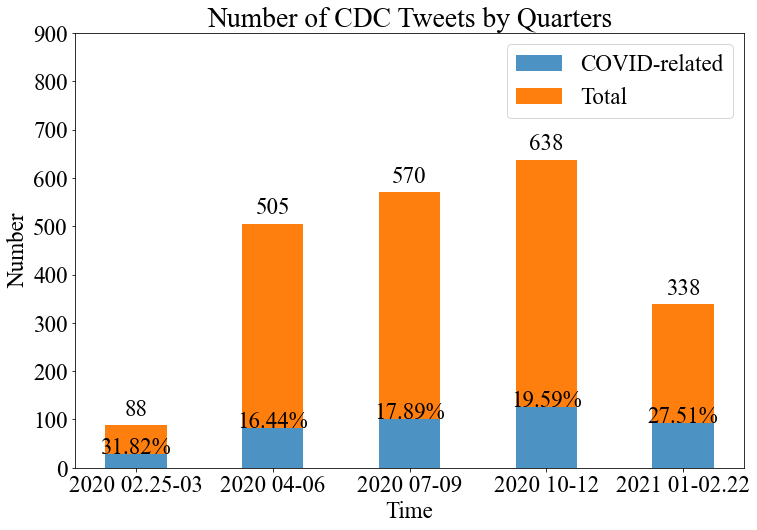

In [133]:
matplotlib.rcParams.update({'font.family' : 'Times New Roman', 'font.size': 23})
fig = plt.figure(figsize = (12,8))
label_list = ['2020 02.25-03', '2020 04-06', '2020 07-09', '2020 10-12', '2021 01-02.22']
num_list1 = [len(tweets01), len(tweets02), len(tweets03), len(tweets04), len(tweets0121)]
num_list2 = [len(all01)-len(tweets01), len(all02)-len(tweets02), len(all03)-len(tweets03), 
             len(all04)-len(tweets04), len(all0121)-len(tweets0121)]
num_list3 = [len(all01), len(all02), len(all03), len(all04), len(all0121)]
x = range(len(num_list1))
rects1 = plt.bar(x=x, height=num_list1, width=0.45, alpha=0.8, label="COVID-related")
rects2 = plt.bar(x=x, height=num_list2, width=0.45, label="Total", bottom=num_list1)

count = 0
count2 = 0
for i in num_list1:
    plt.text(count,i+0.5, str('{:.2f}'.format(num_list1[count]/num_list3[count] *100)) +'%', \
    ha='center') #location, height, content, center
    count+=1 #add percentage
for i in num_list3: 
    plt.text(count2,i+20, str('{}'.format(num_list3[count2])), ha='center')
    count2+=1
    
plt.ylim(0, 900)
plt.ylabel("Number")
plt.xticks(x, label_list)
plt.xlabel("Time")
plt.title("Number of CDC Tweets by Quarters")
plt.legend()
plt.show()

# Word and phrase frequency analysis

## whole CDC COVID tweets

In [135]:
tweets_df[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02


In [136]:
tweetscfdist = nltk.ConditionalFreqDist(((len(w), w) for w in tweets_df['normalized_tokens'].sum()))

#print the number of words
print(tweetscfdist.N())

8106


### The most common 3-16 letter word, and their probabilities

In [137]:
tweetscpdist = nltk.ConditionalProbDist(tweetscfdist, nltk.ELEProbDist)

#print the most common 3-16 letter word, and their probabilities
for i in range(3, 17):
    print(i)
    print(tweetscpdist[i].max())
    print(tweetscpdist[i].prob(tweetscpdist[i].max()))

3
amp
0.1553205551883675
4
case
0.05594210965766769
5
covid
0.2909457900807382
6
spread
0.116796875
7
vaccine
0.10963455149501661
8
forecast
0.05538648813146683
9
community
0.09978070175438597
10
healthcare
0.08113207547169811
11
information
0.13059701492537312
12
asymptomatic
0.08387096774193549
13
administrator
0.19318181818181818
14
recommendation
0.5740740740740741
15
hospitalization
1.0
16
disproportionate
1.0


In [138]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [139]:
tweets_df['normalized_tokens_POS'] = [spacy_pos(t) for t in tweets_df['tweet']]

In [140]:
tweets_df[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month,normalized_tokens_POS
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02,"[( , _SP), (covid, NNP), (19, CD), (and, CC), ..."
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02,"[(a, DT), (new, JJ), (looks, NNS), (at, IN), (..."
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02,"[(officials, NNS), (are, VBP), (concerned, JJ)..."


In [141]:
tweetscfdist_WordtoPOS = nltk.ConditionalFreqDist(tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord['JJ'].most_common(5) # top 5 adjectives

[('covid', 287), ('new', 102), ('national', 26), ('sick', 25), ('many', 25)]

In [142]:
tweetscfdist_POStoWord['NN']

FreqDist({'spread': 100, 'amp': 77, 'vaccine': 64, 'health': 58, 'update': 46, 'risk': 44, 'mask': 40, 'week': 37, 'report': 35, 'call': 35, ...})

In [143]:
tweetscfdist_POStoWord['VB']

FreqDist({'be': 71, 'help': 68, 'learn': 51, 'protect': 36, 'have': 33, 'slow': 32, 'prevent': 27, 'stay': 26, 'wear': 23, 'spread': 23, ...})

### wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

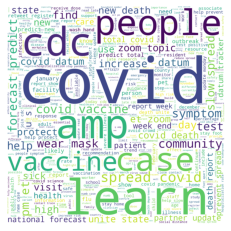

In [144]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, 
                         height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_word_cloud.pdf", format = 'pdf')

In [145]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [146]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):   
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [147]:
tweets_df['sentences'] = tweets_df['tweet'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [148]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [149]:
tweets_df['POS_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_pos(x))

### count the number of verbs

In [150]:
#count the number of VB (verbs)
countTarget = 'VB'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
verb_noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
verb_noun_sortedTargets[:20]

[('be', 71),
 ('help', 68),
 ('learn', 51),
 ('protect', 36),
 ('have', 33),
 ('slow', 32),
 ('prevent', 27),
 ('stay', 26),
 ('wear', 23),
 ('spread', 23),
 ('total', 20),
 ('take', 19),
 ('get', 17),
 ('know', 16),
 ('see', 15),
 ('stop', 14),
 ('reduce', 13),
 ('keep', 12),
 ('join', 10),
 ('wash', 10)]

### count the number of Nouns

In [151]:
#count the number of NN (nouns)
countTarget = 'NN'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
noun_sortedTargets[:20]

[('spread', 100),
 ('amp', 77),
 ('vaccine', 64),
 ('health', 58),
 ('update', 46),
 ('risk', 44),
 ('mask', 40),
 ('week', 37),
 ('report', 35),
 ('call', 35),
 ('community', 29),
 ('pandemic', 28),
 ('contact', 26),
 ('virus', 26),
 ('illness', 25),
 ('cdcs', 24),
 ('zoom', 23),
 ('care', 22),
 ('home', 21),
 ('use', 18)]

In [152]:
def get_modify_word(NTarget, Word):
    NResults = set()
    for entry in tweets_df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-2], sentence[2:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue
    return NResults

In [153]:
#the adjectives that modify the noun
r_jj = {}
for i, v in noun_sortedTargets[:20]:
    #print(i)
    r_jj[i] = get_modify_word("JJ", str(i))
r_jj

{'spread': {'covid', 'likely', 'long', 'rapid', 'slow', 'unlikely'},
 'amp': {'covid', 'key', 'many', 'mental', 'serious', 'sick', 'updated'},
 'vaccine': {'annual', 'covid', 'respiratory', 'variant'},
 'health': {'local', 'national', 'telehealth'},
 'update': set(),
 'risk': {'little'},
 'mask': {'mental'},
 'week': {'public'},
 'report': {'likely'},
 'call': {'next'},
 'community': {'rural'},
 'pandemic': {'covid'},
 'contact': {'covid', 'diagnostic', 'second', 'sick'},
 'virus': {'covid'},
 'illness': {'covid', 'sick'},
 'cdcs': {'covid', 'different', 'new', 'pandemic', 'rural', 'widespread'},
 'zoom': {'available'},
 'care': {'covid', 'long'},
 'home': {'symptomatic'},
 'use': {'available', 'different', 'general', 'similar'}}

In [154]:
#the verbs that modify the noun
r_vb = {}
for i, v in noun_sortedTargets[:20]:
    r_vb[i] = get_modify_word("VB", str(i))
r_vb

{'spread': {'decrease', 'limit', 'lower', 'prevent', 'reduce', 'slow', 'stop'},
 'amp': {'have', 'make', 'protect', 'screen'},
 'vaccine': {'get'},
 'health': set(),
 'update': set(),
 'risk': {'be', 'pose', 'reduce'},
 'mask': {'position', 'put', 'wear'},
 'week': set(),
 'report': {'be', 'collect'},
 'call': {'answer'},
 'community': {'report'},
 'pandemic': {'stop'},
 'contact': {'identify'},
 'virus': {'fight', 'prevent', 'spread'},
 'illness': {'cause', 'have', 'look'},
 'cdcs': {'learn', 'subscribe'},
 'zoom': set(),
 'care': {'get', 'take'},
 'home': {'recover'},
 'use': {'save'}}

### top 10 related adjective and nouns

In [155]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2) or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
adj_noun_pairs = find_part_relation('JJ','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['important', 'part'],
 ['certain', 'health'],
 ['bad', 'reaction'],
 ['second', 'dose'],
 ['second', 'dose'],
 ['first', 'appointment'],
 ['new', 'report'],
 ['current', 'vaccine'],
 ['adolescent', 'immunization'],
 ['real', 'world']]

### top 10 related verbs and nouns

In [156]:
adj_noun_pairs = find_part_relation('VB','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['cause', 'fever'],
 ['share', 'information'],
 ['ensure', 'access'],
 ['support', 'implementation'],
 ['spread', 'wear'],
 ['mask', 'stay'],
 ['find', 'information'],
 ['week', 'see'],
 ['affect', 'pregnancy'],
 ['amp', 'avoid']]

In [157]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2)or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
vb_noun_pairs = find_part_relation('VB','RB',tweets_df['POS_sents'])
vb_noun_pairs[:10]

[['get', 'very'],
 ['nt', 'miss'],
 ['nt', 'live'],
 ['not', 'be'],
 ['safely', 'get'],
 ['nt', 'live'],
 ['also', 'continue'],
 ['increase', 'nationwide'],
 ['also', 'remind'],
 ['nt', 'know']]

### bigrams

In [158]:
#bigrams
tweetsBigrams = nltk.collocations.BigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(tweetsBigrams.N))

def bigramScoring(count, wordsTuple, total):
    return count

print(tweetsBigrams.nbest(bigramScoring, 10))

There are 8106 bigrams in the finder
[('spread', 'covid'), ('covid', 'vaccine'), ('forecast', 'predict'), ('pm', 'et'), ('wear', 'mask'), ('slow', 'spread'), ('zoom', 'topic'), ('covid', 'datum'), ('et', 'zoom'), ('new', 'death')]


In [159]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweetsBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]

[(('pm', 'et'), 479.2373580925537),
 (('forecast', 'predict'), 466.4113797544349),
 (('wear', 'mask'), 336.605535283364),
 (('zoom', 'topic'), 316.1086042444233),
 (('u', 's'), 292.37064165023065),
 (('et', 'zoom'), 275.41524757488617),
 (('slow', 'spread'), 263.72834700658706),
 (('unite', 'state'), 245.62745614309722),
 (('retweet', 'register'), 228.92748282183425),
 (('week', 'end'), 227.10839654348368),
 (('wash', 'hand'), 226.7389386813828),
 (('partner', 'update'), 211.42998495881966),
 (('national', 'forecast'), 209.5745361584621),
 (('datum', 'tracker'), 201.854015111622),
 (('predict', 'total'), 194.58415625249245),
 (('avoid', 'crowd'), 167.95751449905924),
 (('update', 'monday'), 154.28672581505407),
 (('spread', 'covid'), 144.77958476332296),
 (('racial', 'ethnic'), 141.53013457408042),
 (('stay', 'foot'), 140.58230707123255)]

In [160]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

### trigrams, N-grams

In [161]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tweetsTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
tweetsTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('et', 'zoom', 'topic'), 4.898854620081321),
 (('pm', 'et', 'zoom'), 4.898824349660707),
 (('total', 'covid', 'death'), 4.686687202329723),
 (('report', 'week', 'end'), 4.582123764661537),
 (('death', 'report', 'week'), 4.581349027014161),
 (('covid', 'datum', 'tracker'), 4.579869134637737),
 (('new', 'death', 'report'), 4.5796589511834025),
 (('national', 'forecast', 'predict'), 4.471940550305844),
 (('forecast', 'predict', 'total'), 4.471933812212956),
 (('predict', 'total', 'covid'), 4.469871955789399),
 (('forecast', 'predict', 'new'), 4.35815923783493),
 (('predict', 'new', 'death'), 4.357649662793196),
 (('slow', 'spread', 'covid'), 4.230518531157653),
 (('death', 'unite', 'state'), 3.9995766676291176),
 (('covid', 'death', 'unite'), 3.996502303034022),
 (('partner', 'update', 'monday'), 3.8728893320803093),
 (('prevent', 'spread', 'covid'), 3.8629502057169023),
 (('cdc', 'partner', 'update'), 3.463414890006165),
 (('covid', 'science', 'update'), 3.4621530748628984),
 (('help',

In [162]:
Ngrams = nltk.ngrams(tweets_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
#print(Filtered)

In [163]:
print(list(Filtered.items())[:5])

[(('fever', 'cough', 'shortness', 'breath'), 2), (('use', 'chart', 'learn', 'similarity'), 2), (('chart', 'learn', 'similarity', 'difference'), 2), (('learn', 'covid', 'science', 'update'), 2), (('cdcs', 'new', 'covid', 'datum'), 2)]


In [164]:
skipgrams = keras.preprocessing.sequence.skipgrams(tweets_df['normalized_tokens'].sum(), 2000, 2,
                                                        negative_samples=0, shuffle=True, 
                                                        categorical=False, sampling_table=None, seed=None)

In [165]:
skip_con = nltk.ConditionalFreqDist(skipgrams[0])
list(skip_con.items())[:5]

[('health',
  FreqDist({'public': 16, 'covid': 12, 'department': 8, 'amp': 7, 'address': 5, 'mental': 5, 'official': 5, 'local': 5, 'equity': 5, 'dept': 4, ...})),
 ('cope',
  FreqDist({'monitor': 1, 'eat': 1, 'important': 1, 'amp': 1, 'distance': 1, 'resilience': 1, 'healthy': 1, 'promote': 1, 'hard': 1, 'good': 1, ...})),
 ('sure',
  FreqDist({'covid': 4, 'wear': 3, 'spread': 3, 'right': 3, 'vietnamese': 1, 'care': 1, 'language': 1, 'screen': 1, 'let': 1, 'newborn': 1, ...})),
 ('increase',
  FreqDist({'risk': 9, 'covid': 7, 'case': 6, 's': 5, 'rate': 5, 'love': 4, 'show': 4, 'week': 4, 'w': 3, 'people': 3, ...})),
 ('covid',
  FreqDist({'spread': 82, 'vaccine': 58, 'learn': 56, 'datum': 43, 'case': 39, 'cdc': 34, 'death': 33, 'people': 31, 'cdcs': 30, 'update': 25, ...}))]

### entities

In [166]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [167]:
tweets_df['classified_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_ner(x))

In [168]:
tweets_df[:3]

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month,normalized_tokens_POS,sentences,POS_sents,classified_sents
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02,"[( , _SP), (covid, NNP), (19, CD), (and, CC), ...","[[covid, 19, and, flu, can, both, cause, fever...","[[(covid, NNP), (19, CD), (and, CC), (flu, NN)...","[[(covid 19, PERSON)], [(19, CARDINAL)]]"
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02,"[(a, DT), (new, JJ), (looks, NNS), (at, IN), (...","[[a, new, looks, at, in, georgia, elementary, ...","[[(a, DT), (new, JJ), (looks, NNS), (at, IN), ...","[[(georgia, GPE), (19, CARDINAL)]]"
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02,"[(officials, NNS), (are, VBP), (concerned, JJ)...","[[officials, are, concerned, about, variants, ...","[[(officials, NNS), (are, VBP), (concerned, JJ...","[[(the u s, GPE), (uk, GPE), (states, GPE), (1..."


In [169]:
entityCounts = {}
for entry in tweets_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('19', 456),
 ('cdc', 60),
 ('us', 31),
 ('the united states', 24),
 ('pm', 20),
 ('first', 15),
 ('one', 15),
 ('january', 13),
 ('october', 11),
 ('february', 10)]

## quarter 1, 2020 wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

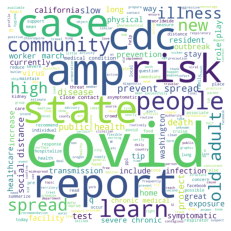

In [170]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, 
                         height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets01['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_01_word_cloud.pdf", format = 'pdf')

## quarter 2, 2020 wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

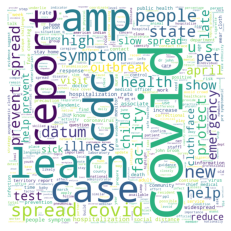

In [171]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, 
                         height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets02['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_02_word_cloud.pdf", format = 'pdf')

## quarter 3, 2020 wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

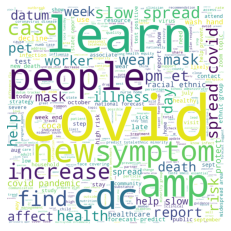

In [172]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000,
                         mode ='RGBA', scale=.5).generate(' '.join(tweets03['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_03_word_cloud.pdf", format = 'pdf')

## quarter 4, 2020 wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

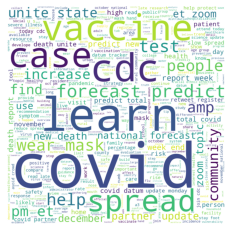

In [173]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, 
                         mode ='RGBA', scale=.5).generate(' '.join(tweets04['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_04_word_cloud.pdf", format = 'pdf')

## quarter 1, 2021 wordcloud

(-0.5, 1499.5, 1499.5, -0.5)

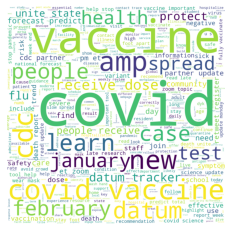

In [174]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, 
                         mode ='RGBA', scale=.5).generate(' '.join(tweets0121['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("covid_tweets_01_21_word_cloud.pdf", format = 'pdf')